In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import re
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [ ]:
data = pd.read_csv("/kaggle/input/datasets/alhanoufalqahtani/azt1dataset/dataset.csv")

In [ ]:
print(f"Dataset shape: {data.shape}")
print(f"Columns: {data.columns.tolist()}")
print(data.head())

data['EventDateTime'] = pd.to_datetime(data['EventDateTime'])
print(f"\nMissing values:\n{data.isnull().sum()}")
data.dropna(inplace=True)


Dataset shape: (306712, 12)
Columns: ['Subject_ID', 'EventDateTime', 'DeviceMode', 'BolusType', 'Basal', 'CorrectionDelivered', 'TotalBolusInsulinDelivered', 'FoodDelivered', 'CarbSize', 'CGM', 'Readings (CGM / BGM)', 'delta_CGM']
   Subject_ID        EventDateTime DeviceMode BolusType  Basal  \
0           1  2024-01-01 00:00:00          0         0    0.0   
1           1  2024-01-01 00:05:00          0         0    0.0   
2           1  2024-01-01 00:10:00          0         0    0.0   
3           1  2024-01-01 00:15:00          0         0    0.0   
4           1  2024-01-01 00:20:00          0         0    0.0   

   CorrectionDelivered  TotalBolusInsulinDelivered  FoodDelivered  CarbSize  \
0                  0.0                         0.0            0.0       0.0   
1                  0.0                         0.0            0.0       0.0   
2                  0.0                         0.0            0.0       0.0   
3                  0.0                         0.0      

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306712 entries, 0 to 306711
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Subject_ID                  306712 non-null  int64         
 1   EventDateTime               306712 non-null  datetime64[ns]
 2   DeviceMode                  306712 non-null  object        
 3   BolusType                   306712 non-null  object        
 4   Basal                       306712 non-null  float64       
 5   CorrectionDelivered         306712 non-null  float64       
 6   TotalBolusInsulinDelivered  306712 non-null  float64       
 7   FoodDelivered               306712 non-null  float64       
 8   CarbSize                    306712 non-null  float64       
 9   CGM                         306712 non-null  float64       
 10  Readings (CGM / BGM)        306712 non-null  float64       
 11  delta_CGM                   306712 non-

In [ ]:
# Extract time features
data['hour'] = data['EventDateTime'].dt.hour
data['day_of_week'] = data['EventDateTime'].dt.dayofweek
data['month'] = data['EventDateTime'].dt.month

print(f"\nData after preprocessing: {data.shape}")


Data after preprocessing: (306712, 15)


In [ ]:
print(data['BolusType'].unique())

['0' 'Automatic Bolus/Correction' 'BLE Standard Bolus/Correction'
 'Standard/Correction' 'BLE Standard Bolus' 'Standard'
 'Extended 50.00%/15.49' 'Extended/Correction 50.00%/23.75'
 'Extended/Correction 50.00%/22.50' 'Extended 50.00%/23.75'
 'Extended/Correction 70.00%/23.75' 'Extended 50.00%/8.57'
 'Extended 50.00%/8.31' 'Extended/Correction 50.00%/5.00'
 'Extended 50.00%/4.29' 'Extended/Correction 50.00%/6.86'
 'Extended/Correction 50.00%/7.14' 'Extended 50.00%/5.40'
 'Extended/Correction 50.00%/6.92' 'Extended 25.00%/4.16'
 'Extended/Correction 50.00%/2.50' 'Extended 60.00%/3.27'
 'Extended 65.00%/3.18' 'Extended/Correction 65.00%/4.57'
 'Extended/Correction 65.00%/3.18' 'Extended/Correction 70.00%/3.18'
 'Extended 50.00%/0.41' 'Extended/Correction 75.00%/2.73'
 'Extended 50.00%/0.00' 'Extended 5.00%/0.00' 'Quick'
 'Extended 25.00%/1.85' 'Extended 10.00%/0.00' 'Extended 50.00%/3.00'
 'Extended/Correction 30.00%/4.75' 'Extended 25.00%/5.60'
 'Extended 25.00%/3.75' 'Extended 50.00%/12

In [ ]:
def parse_extended_bolus(bolus_type):
    """Extract percentage and duration from extended bolus"""
    if pd.isna(bolus_type) or 'Extended' not in str(bolus_type):
        return pd.Series({'percentage': 0, 'duration_hours': 0})

    match = re.search(r'(\d+\.?\d*)%/(\d+\.?\d*)', str(bolus_type))

    if match:
        return pd.Series({
            'percentage': float(match.group(1)),
            'duration_hours': float(match.group(2))
        })
    else:
        return pd.Series({'percentage': 0, 'duration_hours': 0})


In [ ]:
def encode_bolus_type(df):
    """Encode BolusType into binary flags and numeric features"""

    # Binary flags
    df['is_extended'] = df['BolusType'].str.contains('Extended', na=False).astype(int)
    df['is_standard'] = df['BolusType'].str.contains('Standard', na=False).astype(int)
    df['is_automatic'] = df['BolusType'].str.contains('Automatic', na=False).astype(int)
    df['is_quick'] = df['BolusType'].str.contains('Quick', na=False).astype(int)
    df['has_correction'] = df['BolusType'].str.contains('Correction', na=False).astype(int)
    df['is_ble'] = df['BolusType'].str.contains('BLE', na=False).astype(int)
    df['is_no_bolus'] = (df['BolusType'].isna() | (df['BolusType'] == '0')).astype(int)

    # Numeric features for extended boluses
    df[['extended_pct', 'extended_hrs']] = df['BolusType'].apply(parse_extended_bolus)

    return df

# Apply encoding
data = encode_bolus_type(data)

In [ ]:
data = data.sort_values(["Subject_ID", "EventDateTime"]).reset_index(drop=True)

In [ ]:
data=data.drop(['Readings (CGM / BGM)', 'delta_CGM','BolusType'], axis=1)

In [ ]:
data_naive = data[['EventDateTime', 'CGM']].copy(deep=True)
data_naive['prev_CGM'] = data_naive['CGM'].shift(1)
data_naive.dropna(inplace=True)
data_naive['difference'] = data_naive['CGM'] - data_naive['prev_CGM']
data_naive['square_error'] = data_naive['difference'] ** 2

naive_mse = data_naive['square_error'].mean()
print(f'Naive Approach Mean Square Error: {naive_mse:.4f}')

Naive Approach Mean Square Error: 41.8435


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306712 entries, 0 to 306711
Data columns (total 21 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Subject_ID                  306712 non-null  int64         
 1   EventDateTime               306712 non-null  datetime64[ns]
 2   DeviceMode                  306712 non-null  object        
 3   Basal                       306712 non-null  float64       
 4   CorrectionDelivered         306712 non-null  float64       
 5   TotalBolusInsulinDelivered  306712 non-null  float64       
 6   FoodDelivered               306712 non-null  float64       
 7   CarbSize                    306712 non-null  float64       
 8   CGM                         306712 non-null  float64       
 9   hour                        306712 non-null  int32         
 10  day_of_week                 306712 non-null  int32         
 11  month                       306712 non-

In [ ]:
data_enc = pd.get_dummies(data, columns=["DeviceMode"], dummy_na=False)

In [ ]:
feature_columns = [c for c in data_enc.columns if c not in ['Subject_ID','EventDateTime']]
input_data = data_enc[feature_columns].copy()

In [ ]:
# Hyperparameters
T = 96 #Sequence length
D = input_data.shape[1] #Input dimensions
N = len(input_data) - T #Total sequences
H = 1

In [ ]:
print(f"Sequence length (T): {T}")
print(f"Input dimensions (D): {D}")
print(f"Total sequences (N): {N}")

Sequence length (T): 96
Input dimensions (D): 22
Total sequences (N): 306616


In [ ]:
# Train/Val/Test split
train_size = int(len(input_data) * 0.70)
val_size = int(len(input_data) * 0.15)
test_size = N - train_size - val_size

In [ ]:
print(f"\nTrain size: {train_size}")
print(f"Validation size: {val_size}")
print(f"Test size: {test_size}")


Train size: 214698
Validation size: 46006
Test size: 45912


In [ ]:
# Fit scaler on training data only
scaler = StandardScaler()
scaler.fit(input_data[:train_size + T - 1])

# Transform all data using training statistics
input_data_scaled = scaler.transform(input_data)

In [ ]:
print(f" Scaler fit on training data only (indices 0 to {train_size + T - 1})")

 Scaler fit on training data only (indices 0 to 214793)


In [ ]:
# Extract the index column to scale targets consistently
ot_column_idx = feature_columns.index('CGM')
# Get scaled OT values for targets
targets_scaled = input_data_scaled[:, ot_column_idx]

In [ ]:
def create_sequences(data, targets, start_idx, end_idx, T):
    """Create input sequences and targets"""
    n_sequences = end_idx - start_idx
    X = np.zeros((n_sequences, T, data.shape[1]))
    y = np.zeros((n_sequences, 1))

    for i in range(n_sequences):
        t = i + start_idx
        X[i, :, :] = data[t:t+T]
        y[i] = targets[t+T]

    return X, y

In [ ]:
# Create sequences
X_train, y_train = create_sequences(input_data_scaled, targets_scaled, 0, train_size, T)
X_val, y_val = create_sequences(input_data_scaled, targets_scaled, train_size, train_size + val_size, T)
X_test, y_test = create_sequences(input_data_scaled, targets_scaled, train_size + val_size, N, T)

# Convert to PyTorch tensors
X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
X_val = torch.from_numpy(X_val.astype(np.float32))
y_val = torch.from_numpy(y_val.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

print(f"Tensor shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

Tensor shapes:
X_train: torch.Size([214698, 96, 22]), y_train: torch.Size([214698, 1])
X_val: torch.Size([46006, 96, 22]), y_val: torch.Size([46006, 1])
X_test: torch.Size([45912, 96, 22]), y_test: torch.Size([45912, 1])


In [ ]:
BATCH_SIZE = 64

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\nBatch size: {BATCH_SIZE}")
print(f"Training batches per epoch: {len(train_loader)}")



Batch size: 64
Training batches per epoch: 3354


In [ ]:
class PositionalEncoding(nn.Module):
    """Adds positional information to the input embeddings"""
    def __init__(self, d_model, max_len=5000, dropout=0.1):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Create positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Add batch dimension

        self.register_buffer('pe', pe)

    def forward(self, x):
        # x shape: (batch_size, seq_len, d_model)
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)


class TransformerModel(nn.Module):
    """Transformer model for time series prediction"""
    def __init__(self, input_dim, d_model=128, nhead=8, num_layers=2,
                 dim_feedforward=512, dropout=0.2, output_dim=1):
        super(TransformerModel, self).__init__()

        # Input projection layer
        self.input_projection = nn.Linear(input_dim, d_model)

        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model, dropout=dropout)

        # Transformer encoder layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True  # Input shape: (batch, seq, feature)
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Output layer
        self.fc_out = nn.Linear(d_model, output_dim)

        self.d_model = d_model

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_dim)

        # Project input to d_model dimensions
        x = self.input_projection(x)  # (batch, seq, d_model)

        # Add positional encoding
        x = self.pos_encoder(x)

        # Pass through transformer encoder
        x = self.transformer_encoder(x)  # (batch, seq, d_model)

        # Take the output from the last time step
        x = x[:, -1, :]  # (batch, d_model)

        # Final prediction
        output = self.fc_out(x)  # (batch, output_dim)

        return output

In [ ]:
# Model hyperparameters
d_model = 64          # Dimension of the model
nhead = 8              # Number of attention heads
num_layers = 2         # Number of transformer layers
dim_feedforward = 128  # Dimension of feedforward network
dropout = 0.5          # Dropout rate
output_dim = 1         # Single output (CGM prediction)

# Create model
model = TransformerModel(
    input_dim=D,
    d_model=d_model,
    nhead=nhead,
    num_layers=num_layers,
    dim_feedforward=dim_feedforward,
    dropout=dropout,
    output_dim=output_dim
)
model.to(device)

print(f"\nModel: {sum(p.numel() for p in model.parameters())} parameters")


Model: 68481 parameters


In [ ]:
def train(model, train_loader, val_loader, learning_rate=0.001, epochs=100, patience=15):

    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5
    )

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss_batches = []

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss_batches.append(loss.item())

        avg_train_loss = np.mean(train_loss_batches)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss_batches = []

        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss_batches.append(loss.item())

        avg_val_loss = np.mean(val_loss_batches)
        val_losses.append(avg_val_loss)

        scheduler.step(avg_val_loss)

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_transformer_model.pth')
        else:
            patience_counter += 1

        if (epoch + 1) % 5 == 0:
            print(f'Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

        if patience_counter >= patience:
            print(f'\nEarly stopping at epoch {epoch+1}')
            break

    # Load best model
    model.load_state_dict(torch.load('best_transformer_model.pth'))
    return train_losses, val_losses

In [ ]:
train_losses, val_losses = train(
    model, train_loader, val_loader,
    learning_rate=0.001, epochs=100, patience=15
)

Epoch 5/100 - Train Loss: 0.0385, Val Loss: 0.0173
Epoch 10/100 - Train Loss: 0.0361, Val Loss: 0.0222
Epoch 15/100 - Train Loss: 0.0306, Val Loss: 0.0240
Epoch 20/100 - Train Loss: 0.0277, Val Loss: 0.0225

Early stopping at epoch 20


In [ ]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', alpha=0.7)
plt.plot(val_losses, label='Validation Loss', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss (Scaled)')
plt.title('Training History')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
model.eval()
test_predictions_scaled = []
test_targets_scaled = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        test_predictions_scaled.extend(outputs.cpu().numpy().flatten())
        test_targets_scaled.extend(batch_y.numpy().flatten())

test_predictions_scaled = np.array(test_predictions_scaled)
test_targets_scaled = np.array(test_targets_scaled)

In [ ]:
# Get scaler parameters for OT column
ot_mean = scaler.mean_[ot_column_idx]
ot_std = scaler.scale_[ot_column_idx]

# Inverse transform: original = scaled * std + mean
test_predictions = test_predictions_scaled * ot_std + ot_mean
test_targets = test_targets_scaled * ot_std + ot_mean

print(f"Predictions and targets converted to original scale")

# Calculate metrics on ORIGINAL scale
mse = np.mean((test_targets - test_predictions) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(test_targets - test_predictions))
r2   = r2_score(test_targets, test_predictions)

print(f"  MSE:  {mse:.4f}")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAE:  {mae:.4f}")
print(f"  R2:  {r2:.4f}")


Predictions and targets converted to original scale
  MSE:  36.3333
  RMSE: 6.0277
  MAE:  4.0278
  R2:  0.9804


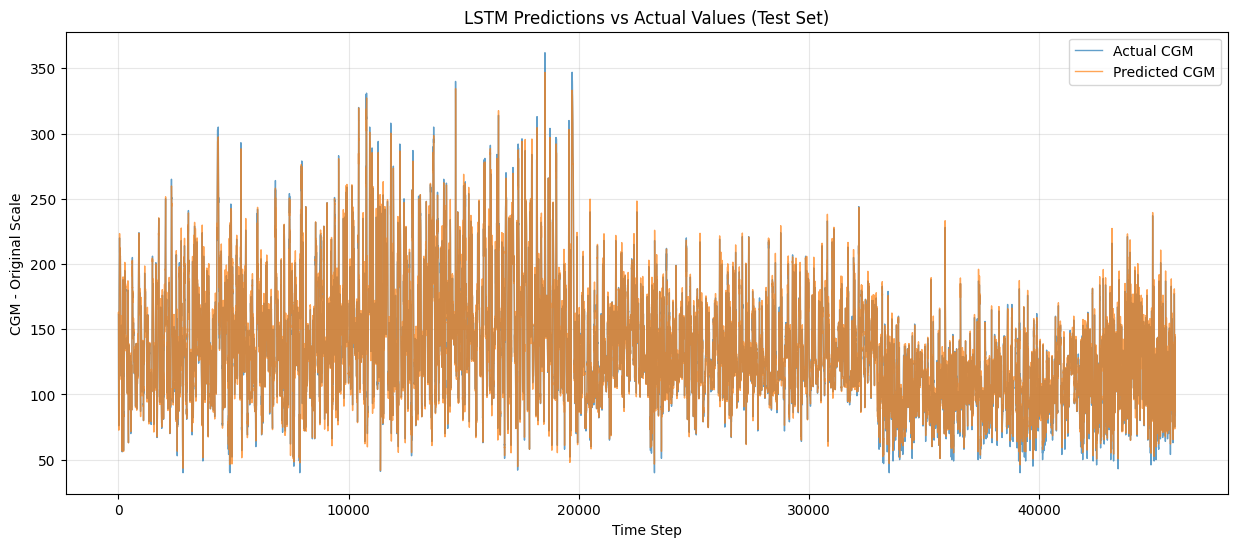

In [ ]:
plt.figure(figsize=(15, 6))
plot_samples = min(len(test_predictions), len(test_predictions))
plt.plot(test_targets[:plot_samples], label='Actual CGM', linewidth=1, alpha=0.7)
plt.plot(test_predictions[:plot_samples], label='Predicted CGM', linewidth=1, alpha=0.7)
plt.xlabel('Time Step')
plt.ylabel('CGM - Original Scale')
plt.title('LSTM Predictions vs Actual Values (Test Set)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

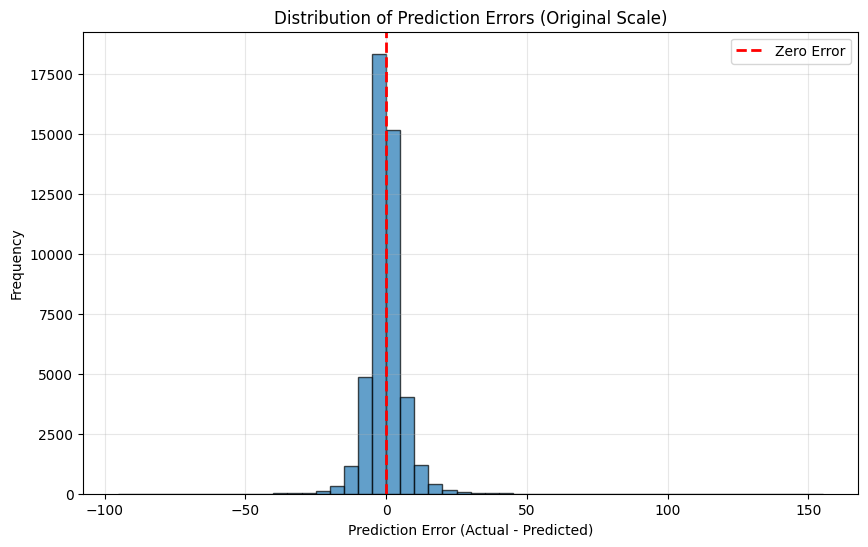

In [ ]:
errors = test_targets - test_predictions
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Prediction Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors (Original Scale)')
plt.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

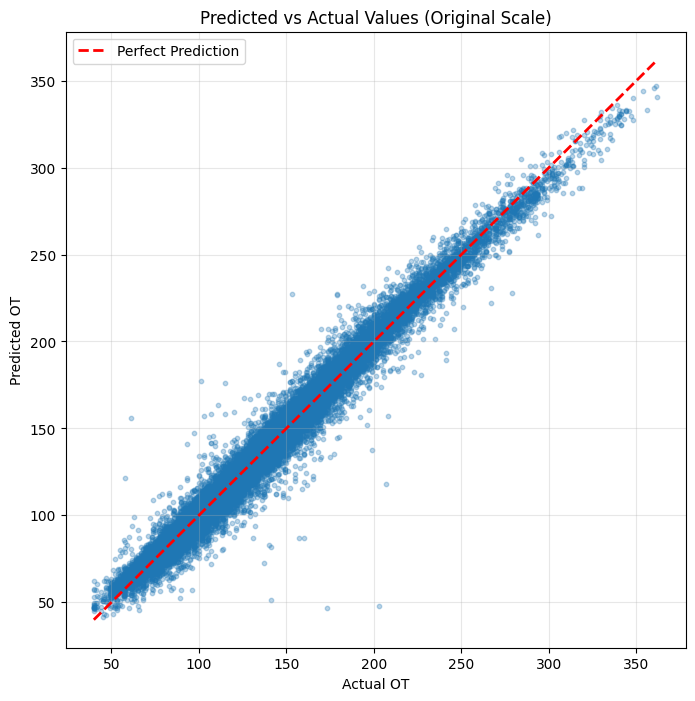

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(test_targets, test_predictions, alpha=0.3, s=10)
plt.plot([test_targets.min(), test_targets.max()],
         [test_targets.min(), test_targets.max()],
         'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel('Actual OT')
plt.ylabel('Predicted OT')
plt.title('Predicted vs Actual Values (Original Scale)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()